# Generate Synthetic Images


In [1]:
import numpy as np
from skimage.draw import disk, ellipse, rectangle
from skimage.io import imshow, imsave
import random
import math

In [2]:
def check_overlap(center1, center2, distance):
    return np.sqrt(np.sum((np.array(center1) - np.array(center2)) ** 2)) < distance


def ellipse_perimeter(a, b):
    """
    Calculate the perimeter of an ellipse using Ramanujan's approximation.
    
    Parameters:
    - a: Semi-major axis of the ellipse
    - b: Semi-minor axis of the ellipse
    
    Returns:
    - The approximate perimeter of the ellipse
    """
    return math.pi * (3*(a + b) - math.sqrt((3*a + b) * (a + 3*b)))


def generate_shapes(circle_radius=50, ellipse_width=100, ratio=0.5,overlap_distance=None,square_side=100, path=None, seed=None):

    if seed is not None:
        random.seed(seed) 

    img = np.zeros((2048, 2048), dtype=np.uint16)  # Create a black 16-bit grayscale image
    ground_truth = [] 

    # Generate 1 circle
    center = [random.randint(circle_radius, 2048-circle_radius), random.randint(circle_radius, 2048-circle_radius)]  # Randomly specify center
    rr, cc = disk(center, circle_radius)
    img[rr, cc] = 65535
    ground_truth.append({'Area': math.pi * circle_radius ** 2,'Centroid_Y': center[0],'Centroid_X': center[1],'Perimeter': 2 * math.pi * circle_radius})  

    # Generate 1 ellipse with specified eccentricity
    height = ellipse_width * ratio
    center_ellipse = [random.randint(ellipse_width//2, 2048-ellipse_width//2), random.randint(height//2, 2048-height//2)]  # Randomly specify center
    while check_overlap(center, center_ellipse, circle_radius + max(ellipse_width//2, height//2)):  # Ensure the ellipse does not overlap with the circle
        center_ellipse = [random.randint(ellipse_width//2, 2048-ellipse_width//2), random.randint(height//2, 2048-height//2)]
    rr, cc = ellipse(center_ellipse[0], center_ellipse[1], ellipse_width//2, height//2)
    img[rr, cc] = 65535
    ground_truth.append({ 'Area': math.pi * (ellipse_width//2) * (height//2),'Centroid_Y': center_ellipse[0],'Centroid_X': center_ellipse[1],'Perimeter':ellipse_perimeter(ellipse_width//2,height//2)})  

    # Generate 1 square
    start = (random.randint(0, 2048-square_side), random.randint(0, 2048-square_side))  # Randomly specify start
    while check_overlap(center, start, circle_radius + square_side) or check_overlap(center_ellipse, start, max(ellipse_width//2, height//2) + square_side):  # Ensure the square does not overlap with the circle or the ellipse
        start = (random.randint(0, 2048-square_side), random.randint(0, 2048-square_side))
    rr, cc = rectangle(start, extent=(square_side, square_side))
    img[rr, cc] = 65535
    ground_truth.append({'Area': square_side**2,'Centroid_Y':(start[0]+square_side//2),'Centroid_X':(start[1]+square_side//2),'Perimeter':square_side*4})  # Add to ground truth
    
    # Add 2 overlapping circles

    if overlap_distance == None:
        overlap_distance = circle_radius // 2 
         
    center1 = np.array([random.randint(circle_radius, 2048-circle_radius-2*overlap_distance), random.randint(circle_radius, 2048-circle_radius-2*overlap_distance)])
    center2 = center1 + np.array([overlap_distance, overlap_distance])  # Calculate the center of the second circle based on the overlap distance
    while check_overlap(center, center1, 2 * circle_radius) or check_overlap(center_ellipse, center1, max(ellipse_width//2, height//2) + circle_radius) or check_overlap(center, center2, 2 * circle_radius) or check_overlap(center_ellipse, center2, max(ellipse_width//2, height//2) + circle_radius) or check_overlap(start, center1, square_side + circle_radius) or check_overlap(start, center2, square_side + circle_radius):  # Ensure the overlapping circles do not overlap with the single circle, the ellipse, or the square
        center1 = np.array([random.randint(circle_radius, 2048-circle_radius), random.randint(circle_radius, 2048-circle_radius)])
        center2 = center1 + np.array([overlap_distance, overlap_distance])
    rr, cc = disk(center1, circle_radius)
    img[rr, cc] = 65535
    rr, cc = disk(center2, circle_radius)
    img[rr, cc] = 65535
#######
    # Calculate the perimeter of each circle
    perimeter_each_circle = 2 * math.pi * circle_radius

    # Calculate the arc length in radians
    arc_length_rad = 2 * math.acos((circle_radius - overlap_distance) / circle_radius)

    # Convert the arc length to length units
    arc_length = arc_length_rad * circle_radius

    # Calculate the total perimeter of the overlapping circles
    total_perimeter = 2 * perimeter_each_circle - 2 * arc_length
    
    # Calculate the area of each sector
    area_each_sector = (arc_length_rad / (2 * math.pi)) * math.pi * circle_radius**2

    area_each_triangle = (circle_radius**2 / 2) * math.sin(arc_length_rad)

    area_each_circle = math.pi * circle_radius**2

    area_overlap = 2 * area_each_sector - 2 * area_each_triangle

    # Calculate the total area of the two circles including the overlapping region
    total_area = 2 * area_each_circle - area_overlap

    ground_truth.append({'Area': total_area,'Centroid_Y': [(center1 + center2) / 2][0][0],'Centroid_X': [(center1 + center2) / 2][0][1],'Perimeter':total_perimeter})  # Add to ground truth
    imshow(img, cmap='gray')
    if path!=None:
        imsave(path, img)

    # Generate ground truth
    

    return img, ground_truth

# Generate synthetic images and ground truth measurements

In [3]:
%load_ext autoreload
%autoreload 2

import os
import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

import tifffile as TIFF
from matplotlib import cm
from skimage import io
import PyPlaque

from PyPlaque.utils import get_plaque_mask, PlaqueImageReadout
from PyPlaque.experiment import ExperimentFluorescencePlaque

In [4]:
#Generate 5 images and ground truth
data=[]

for i in range(1, 6):
    img,gt = generate_shapes(circle_radius=150, ellipse_width=300, ratio=0.4, square_side=400,seed=i)
    filename = f"A0{i}_w2.TIF"
    data.extend(gt) 
    imsave(filename, img)


# Convert the list of dictionaries to a DataFrame
    

df = pd.DataFrame(data)
print(df.head())
#order columns
df= df[['Area','Centroid_X','Centroid_Y','Perimeter']]
# Optionally, save the DataFrame to a CSV file
# df.to_csv("gt_res.csv", index=False)

# Generate PyPlaque measurements on the synthetic images

In [4]:
import numpy as np
import pandas as pd

import tifffile as TIFF
from scipy import ndimage as ndi
from pathlib import Path
import PyPlaque

from PyPlaque.utils import get_plaque_mask, PlaqueImageReadout


In [5]:
STREL_4 = np.array([[0, 1, 0],
                    [1, 1, 1],
                    [0, 1, 0]], dtype=np.uint8)
STREL_8 = np.ones((3, 3), dtype=np.uint8)

def picks_area(image, neighbourhood=4):
    if neighbourhood == 4:
        strel = STREL_4
    elif neighbourhood == 8:
        strel = STREL_8
    image = image.astype(np.uint8)
    eroded_image = ndi.binary_erosion(image, strel, border_value=0)
    border_image = image - eroded_image

    perimeter_weights = np.zeros(50, dtype=np.double)
    perimeter_weights[[5, 7, 15, 17, 25, 27]] = 0.25
    perimeter_weights[[21, 33]] = 1
    perimeter_weights[[13, 23]] = 0.125

    perimeter_image = ndi.convolve(border_image, np.array([[10, 2, 10],
                                                           [2, 1, 2],
                                                           [10, 2, 10]]),
                                   mode='constant', cval=0)
    # perimeter_histogram = np.bincount(perimeter_image.ravel(), minlength=50)
    perimeter_histogram = np.histogram(perimeter_image.ravel(), bins=50)
    total_perimeter = np.dot(perimeter_histogram[0], perimeter_weights)

    v = np.count_nonzero(eroded_image)

    if v == 0:
        s = total_perimeter
    else:
        s = v + total_perimeter / 2 - 1

    return s

def new_std_perimeter(image, neighbourhood=4):
    STREL_4 = np.array([[0, 1, 0],
                        [1, 1, 1],
                        [0, 1, 0]], dtype=np.uint8)
    STREL_8 = np.ones((3, 3), dtype=np.uint8)

    if neighbourhood == 4:
        strel = STREL_4
    else:
        strel = STREL_8
    image = image.astype(np.uint8)

    (w, h) = image.shape
    data = np.zeros((w + 2, h + 2), dtype=image.dtype)
    data[1:-1, 1:-1] = image
    image = data

    eroded_image = ndi.binary_dilation(image, strel, border_value=0)
    border_image = eroded_image - image

    perimeter_weights = np.zeros(50, dtype=np.double)
    perimeter_weights[[5, 7, 15, 17, 25, 27]] = 1
    perimeter_weights[[21, 33]] = np.sqrt(2)
    perimeter_weights[[13, 23]] = (1 + np.sqrt(2)) / 2

    perimeter_image = ndi.convolve(border_image, np.array([[10, 2, 10],
                                                           [2, 1, 2],
                                                           [10, 2, 10]]),
                                   mode='constant', cval=0)

    # perimeter_histogram = np.bincount(perimeter_image.ravel(), minlength=50)
    perimeter_histogram = np.histogram(perimeter_image.ravel(), bins=50)
    total_perimeter = np.dot(perimeter_histogram[0], perimeter_weights)
    return total_perimeter


In [6]:
image_bits = 16

params_w2 = {
    'min_plaque_area': 2000,
    'virus_threshold': 0.032* (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 200,
    'plaque_gaussian_filter_sigma': 100,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 120
}


In [7]:
# Initialize dictionary for plate
d = 'synthetic_images_plate'
plate_dict = {}
plate_dict[d] = {}
plate_dict[d]['img'] = {}
plate_dict[d]['mask'] = {}
plate_dict[d]['image_name'] = {}

# Initialize an empty DataFrame
output = []

image_path = Path('../../../../data_backup/synthetic_images/data')
image_files = [f for f in image_path.glob('*.TIF')]
print(image_files)
image_files = sorted(image_files)

img_list = [TIFF.imread(f) for f in image_files]
mask_list = [get_plaque_mask(img,params_w2)[0] for img in img_list]


plate_dict[d]['img'] = img_list
plate_dict[d]['image_name'] = image_files
plate_dict[d]['mask'] = mask_list

[PosixPath('../../../../data_backup/synthetic_images/data/A04_w2.TIF'), PosixPath('../../../../data_backup/synthetic_images/data/A02_w2.TIF'), PosixPath('../../../../data_backup/synthetic_images/data/A05_w2.TIF'), PosixPath('../../../../data_backup/synthetic_images/data/A03_w2.TIF'), PosixPath('../../../../data_backup/synthetic_images/data/A01_w2.TIF')]


../../../../data_backup/synthetic_images/data/A03_w2.TIF


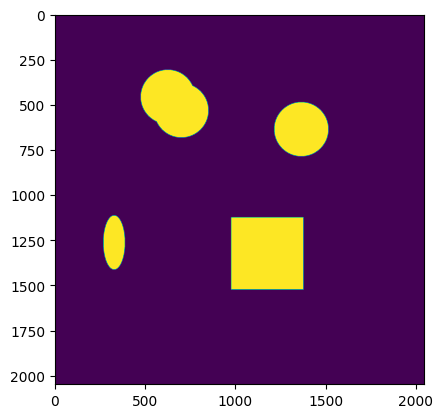

In [8]:
print(plate_dict[d]['image_name'][2])
plt.imshow(plate_dict[d]['img'][2])

In [9]:
len(img_list)

5

In [10]:
output = []
pad = 10
for i in range(len(img_list)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=str(plate_dict[d]
                                        ['image_name'][i]).split("/")[-1],
                            plaque_image_name=str(plate_dict[d]['image_name'][i]).split("/")[-1],
                            nuclei_image=np.array(plate_dict[d]['img'][i]),
                            plaque_image=np.array(plate_dict[d]['img'][i]),
                            nuclei_mask=np.array(plate_dict[d]['mask'][i]),
                            plaque_mask=np.array(plate_dict[d]['mask'][i]),
                            virus_params=params_w2)

    well_id = plq_image_readout.plaque_image_name.split("_")[0]
    col_id = int(well_id[1:])

    plq_objects = plq_image_readout.get_plaque_objects()

    if len(plq_objects) != 0:
        plq_object_readouts = [plq_image_readout.call_plaque_object_readout(plq_object,params_w2) 
                                                                for plq_object in plq_objects]
        for plq_object_readout in plq_object_readouts:
            # plt.figure()
            # plt.imshow(plate_dict[d]['img'][i][(plq_object_readout.get_bbox()[0]-pad) : (plq_object_readout.get_bbox()[0]+plq_object_readout.get_bbox()[2]+pad),
            # (plq_object_readout.get_bbox()[1]-plq_object_readout.get_bbox()[3]-pad) : (plq_object_readout.get_bbox()[1]+pad)]
            #             )

            data = {
                        'Area': picks_area(plate_dict[d]['img'][i][(plq_object_readout.get_bbox()[0]-pad) : (plq_object_readout.get_bbox()[0]+plq_object_readout.get_bbox()[2]+pad),
                                (plq_object_readout.get_bbox()[1]-plq_object_readout.get_bbox()[3]-pad) : (plq_object_readout.get_bbox()[1]+pad)]),
                        'Centroid_X': plq_object_readout.get_centroid()[1],
                        'Centroid_Y': plq_object_readout.get_centroid()[0],
                        'Perimeter': new_std_perimeter(plate_dict[d]['img'][i][(plq_object_readout.get_bbox()[0]-pad) : (plq_object_readout.get_bbox()[0]+plq_object_readout.get_bbox()[2]+pad),
                                (plq_object_readout.get_bbox()[1]-plq_object_readout.get_bbox()[3]-pad) : (plq_object_readout.get_bbox()[1]+pad)]),
                    }
                
            output.append(data)

# Create a DataFrame from the list of dictionaries
output_df = pd.DataFrame(output)
print(output_df)

0
1
2
3
4
        Area  Centroid_X  Centroid_Y    Perimeter
0    69812.0      1315.0       425.0   988.000000
1   100779.0       428.5       709.5  1238.828427
2   158403.0       328.5      1763.5  1604.000000
3    27588.0      1703.0      1885.0   704.000000
4    27588.0       233.0       337.0   704.000000
5   100779.0       702.5       818.5  1238.828427
6   158403.0      1570.5      1706.5  1604.000000
7    69812.0       265.0      1888.0   988.000000
8   100779.0       661.5       495.5  1238.828427
9    69812.0      1363.0       637.0   988.000000
10   27588.0       327.0      1264.0   704.000000
11  158403.0      1174.5      1324.5  1604.000000
12   27588.0      1537.0       361.0   704.000000
13  158403.0       383.5       516.5  1604.000000
14   69812.0       771.0       633.0   988.000000
15  100779.0      1312.5      1009.5  1238.828427
16  100779.0      1776.5      1140.5  1238.828427
17  158403.0       258.5      1284.5  1604.000000
18   69812.0       673.0      1425.0   9

In [11]:
# Save the DataFrame to a CSV file
# output_df.to_csv("../../../../data_backup/synthetic_images/pyplaque_res_picks.csv", index=False)

# Compare readouts

In [12]:
gt_df = pd.read_csv("../../../../data_backup/synthetic_images/gt_res.csv")
pyplaque_df = pd.read_csv("../../../../data_backup/synthetic_images/pyplaque_res_picks.csv")
scikit_image_df = pd.read_csv("../../../../data_backup/synthetic_images/pyplaque_res.csv")
matlab_df = pd.read_csv("../../../../data_backup/synthetic_images/matlab_res.csv")
fiji_df = pd.read_csv("../../../../data_backup/synthetic_images/fiji_res.csv")   

# Each of these have 20 rows (5 images and 4 objects in each, 1 of each category)
# We now need to consolidate metrics over these 4 object categories from the 5 images
gt_df = gt_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
pyplaque_df = pyplaque_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
scikit_image_df = scikit_image_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
matlab_df = matlab_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])
fiji_df = fiji_df.sort_values(by=['Area','Centroid_X','Centroid_Y'], ascending=[True, True, True])

# indices here are indicative of the shapes, so 0-3 inclusive are shapes in synthetic image #1, 
# 4-7 in synthetic image #2 and so on
# Now we use the integer division of indices to get all row indices corresponding to one shape to a single value

gt_df = gt_df.reset_index(drop=True)
pyplaque_df = pyplaque_df.reset_index(drop=True)
scikit_image_df = scikit_image_df.reset_index(drop=True)
matlab_df = matlab_df.reset_index(drop=True)
fiji_df = fiji_df.reset_index(drop=True)

average_gt_df = gt_df.groupby(gt_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_pyplaque_df = pyplaque_df.groupby(pyplaque_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_scikit_image_df = scikit_image_df.groupby(scikit_image_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_matlab_df = matlab_df.groupby(matlab_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])
average_fiji_df = fiji_df.groupby(fiji_df.index // 5).mean().drop(columns=['Centroid_X', 'Centroid_Y'])

average_gt_df = average_gt_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_pyplaque_df = average_pyplaque_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_scikit_image_df = average_scikit_image_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_matlab_df = average_matlab_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])
average_fiji_df = average_fiji_df.sort_values(by=['Area','Perimeter'], ascending=[True, True])

std_gt_df = gt_df.groupby(gt_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])
std_pyplaque_df = pyplaque_df.groupby(pyplaque_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])
std_scikit_image_df = scikit_image_df.groupby(scikit_image_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])
std_matlab_df = matlab_df.groupby(matlab_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])
std_fiji_df = fiji_df.groupby(fiji_df.index // 5).std().drop(columns=['Centroid_X', 'Centroid_Y'])

# average_gt_df = average_gt_df.sort_index()
# average_pyplaque_df = average_pyplaque_df.sort_index()
# average_matlab_df = average_matlab_df.sort_index()
# average_fiji_df = average_fiji_df.sort_index()




In [13]:
import pandas as pd

# Concatenate all dataframes into one
all_dfs = pd.concat([average_gt_df, average_pyplaque_df, average_scikit_image_df, average_matlab_df, average_fiji_df])

# Sort by 'Area'
all_dfs = all_dfs.sort_values(by='Area')

# Initialize 'Area_Group' with -1
all_dfs['Area_Group'] = -1

# Initialize the group number and the 'Area' of the previous row
group_num = 0
prev_area = all_dfs.iloc[0]['Area']

# Threshold for the difference in 'Area'
threshold = 10

# Iterate over the rows
for i in range(len(all_dfs)):
    # If the difference in 'Area' is less than the threshold, assign the same group number
    if abs(all_dfs.iloc[i]['Area'] - prev_area) < threshold:
        all_dfs.iloc[i]['Area_Group'] = group_num
    # If the difference in 'Area' is greater than or equal to the threshold, increment the group number and assign it
    else:
        group_num += 1
        all_dfs.iloc[i]['Area_Group'] = group_num

    # Update the 'Area' of the previous row
    prev_area = all_dfs.iloc[i]['Area']

print('GT:')
print(average_gt_df)
print('PYPLAQUE:')
print(average_pyplaque_df)
print('SCIKIT-IMAGE:')
print(average_scikit_image_df)
print('MATLAB:')
print(average_matlab_df)
print('FIJI:')
print(average_fiji_df)

GT:
            Area    Perimeter
0   28274.333882   690.384369
1   70685.834706   942.477796
2  113733.351193  1256.637061
3  160000.000000  1600.000000
PYPLAQUE:
       Area    Perimeter
0   27588.0   704.000000
1   69812.0   988.000000
2  100779.0  1238.828427
3  158403.0  1604.000000
SCIKIT-IMAGE:
       Area    Perimeter
0   28233.0   721.872150
1   70661.0   990.489465
2  101806.0  1219.023520
3  160000.0  1596.000000
MATLAB:
       Area  Perimeter
0   28233.0    686.456
1   70661.0    939.000
2  101806.0   1155.220
3  160000.0   1563.716
FIJI:
       Area  Perimeter
0   28233.0    722.943
1   70661.0    991.561
2  101806.0   1218.923
3  160000.0   1597.657


/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_17739/2734948987.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs.iloc[i]['Area_Group'] = group_num
/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_17739/2734948987.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs.iloc[i]['Area_Group'] = group_num


In [14]:
import pandas as pd

# Assuming the dataframes are already sorted by index
df = pd.concat([average_gt_df, average_pyplaque_df, average_matlab_df, average_fiji_df], axis=0, keys=['GT', 'pyplaque', 'matlab', 'fiji'])

# Reset the index and drop it
df = df.reset_index(drop=True)

print(df)

latex_table = df.to_latex(index=False)

print(latex_table)

             Area    Perimeter
0    28274.333882   690.384369
1    70685.834706   942.477796
2   113733.351193  1256.637061
3   160000.000000  1600.000000
4    27588.000000   704.000000
5    69812.000000   988.000000
6   100779.000000  1238.828427
7   158403.000000  1604.000000
8    28233.000000   686.456000
9    70661.000000   939.000000
10  101806.000000  1155.220000
11  160000.000000  1563.716000
12   28233.000000   722.943000
13   70661.000000   991.561000
14  101806.000000  1218.923000
15  160000.000000  1597.657000
\begin{tabular}{rr}
\toprule
         Area &   Perimeter \\
\midrule
 28274.333882 &  690.384369 \\
 70685.834706 &  942.477796 \\
113733.351193 & 1256.637061 \\
160000.000000 & 1600.000000 \\
 27588.000000 &  704.000000 \\
 69812.000000 &  988.000000 \\
100779.000000 & 1238.828427 \\
158403.000000 & 1604.000000 \\
 28233.000000 &  686.456000 \\
 70661.000000 &  939.000000 \\
101806.000000 & 1155.220000 \\
160000.000000 & 1563.716000 \\
 28233.000000 &  722.943000 \\
 

/var/folders/ww/drh8wc992nxcqb4z8dmykc440000gn/T/ipykernel_17739/915451732.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=False)
